# Lab №3 - Potential Field-Based Path Planning

### 0. Import the necessary libraries

In [180]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import deque
from mpl_toolkits.mplot3d import Axes3D

### 1. Define map dimensions and create obstacles

In [181]:
map_height = 250
map_width = 300
binary_map = np.zeros((map_height, map_width), dtype=np.uint8)

# Define polygon and circle obstacles
polygon_obstacles = [
    np.array([[40, 40], [70, 10], [90, 50], [60, 90], [30, 70]], np.int32),
    np.array([[160, 20], [190, 10], [180, 45]], np.int32),
    np.array([[220, 30], [250, 30], [250, 70], [230, 90], [215, 70], [210, 45]], np.int32),
    np.array([[200, 160], [230, 120], [230, 150]], np.int32),
    np.array([[140, 80], [160, 130], [130, 110]], np.int32),
    np.array([[100, 150], [140, 170], [110, 180], [90, 170], [80, 160]], np.int32),
    np.array([[50, 150], [70, 180], [40, 190]], np.int32),
]

circle_obstacles = [
    (120, 40, 15),
    (180, 180, 10),
    (30, 120, 12)
]

# Draw the obstacles
for obs in polygon_obstacles:
    cv2.fillPoly(binary_map, [obs], 1)

for x, y, r in circle_obstacles:
    cv2.circle(binary_map, (x, y), r, 1, -1)

Plot Obstacle Map

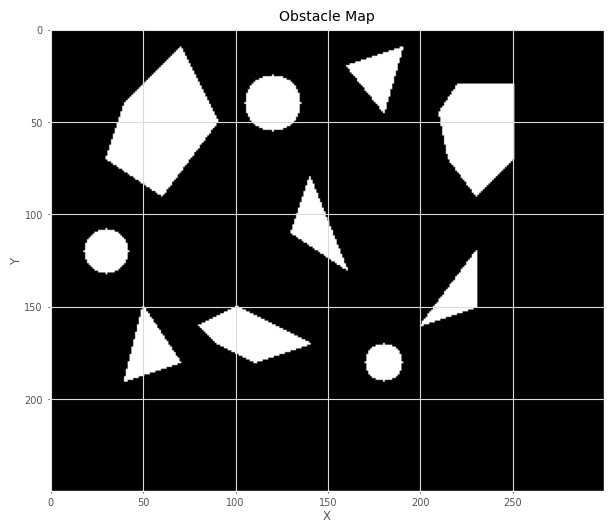

In [182]:
plt.figure(figsize=(8,6))
plt.imshow(binary_map, cmap='gray')
plt.title("Obstacle Map")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


2. Compute Distance Map

In [183]:
def compute_distance_map(binary_map):
    height, width = binary_map.shape
    distance_map = np.full((height, width), 10000, dtype=np.float32)
    queue = deque()

    for x in range(height):
        for y in range(width):
            if binary_map[x, y] == 1:
                distance_map[x, y] = 0.0
                queue.append((x, y))

    neighbors = [(-1, -1), (-1, 0), (-1, 1),
                 (0, -1),           (0, 1),
                 (1, -1),  (1, 0),  (1, 1)]

    while queue:
        x, y = queue.popleft()
        for dx, dy in neighbors:
            nx, ny = x + dx, y + dy
            if 0 <= nx < height and 0 <= ny < width:
                step_distance = np.sqrt(dx**2 + dy**2)
                new_distance = distance_map[x, y] + step_distance
                if new_distance < distance_map[nx, ny]:
                    distance_map[nx, ny] = new_distance
                    queue.append((nx, ny))
    return distance_map

distance_map = compute_distance_map(binary_map)


Plot Distance Map

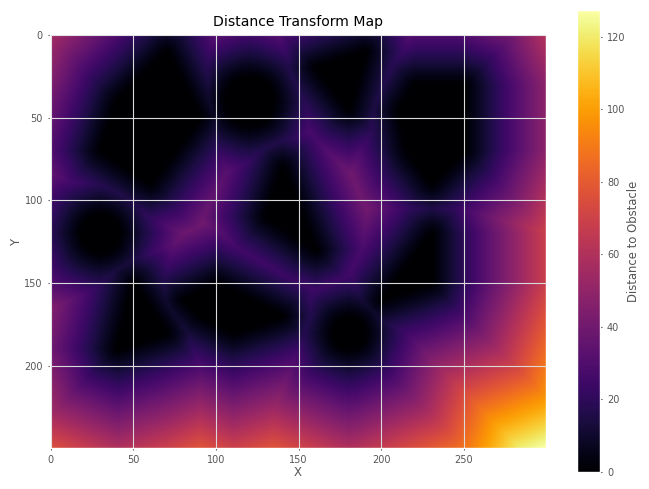

In [184]:
plt.figure(figsize=(8,6))
plt.imshow(distance_map, cmap='inferno')
plt.colorbar(label="Distance to Obstacle")
plt.title("Distance Transform Map")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


3. Define Start and Goal

In [185]:
# Set start and goal locations
start = np.array([25, 25])
goal = np.array([150, 220])

# Clip to map boundaries
goal[0] = np.clip(goal[0], 0, map_width-1)
goal[1] = np.clip(goal[1], 0, map_height-1)
start[0] = np.clip(start[0], 0, map_width-1)
start[1] = np.clip(start[1], 0, map_height-1)


4. Attractive Potential Field

In [186]:
def attrac_field(binary_map, goal, k_att=0.1):
    height, width = binary_map.shape
    return np.fromfunction(lambda x, y: 0.5 * k_att * np.sqrt((y - goal[0])**2 + (x - goal[1])**2), (height, width), dtype=np.float32)

attrac_field_map = attrac_field(binary_map, goal)


Plot Attractive Field

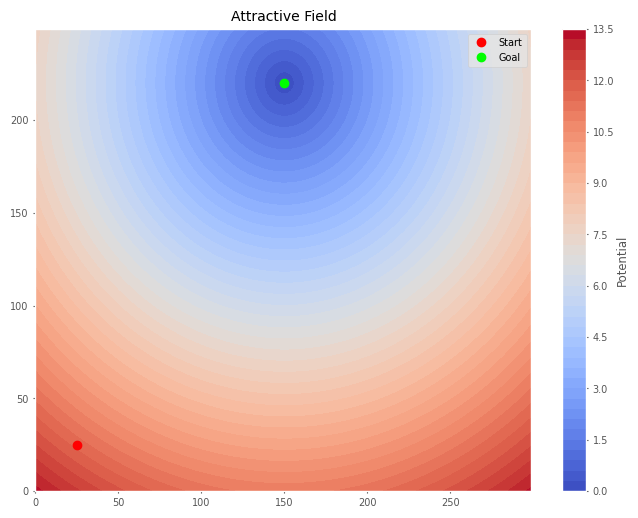

In [198]:
plt.figure(figsize=(8,6))
plt.contourf(attrac_field_map, levels=50, cmap='coolwarm')
plt.plot(start[0], start[1], 'o', color=[1, 0, 0], label="Start")
plt.plot(goal[0], goal[1], 'o', color=[0, 1, 0], label="Goal")
plt.title("Attractive Field")
plt.colorbar(label="Potential")
plt.legend()
plt.show()


 5. Repulsive Potential Field

In [188]:
def safe_distance_map(distance_map, epsilon=1e-3):
    return np.clip(distance_map, epsilon, None)

def repul_field(binary_map, distance_map, k_repul=100.0, tolerance=25):
    safe_dist = safe_distance_map(distance_map)
    return np.where(safe_dist <= tolerance, 0.5 * k_repul * ((1/safe_dist - 1/tolerance)**2), 0)

repul_field_map = repul_field(binary_map, distance_map)


Plot Repulsive Field

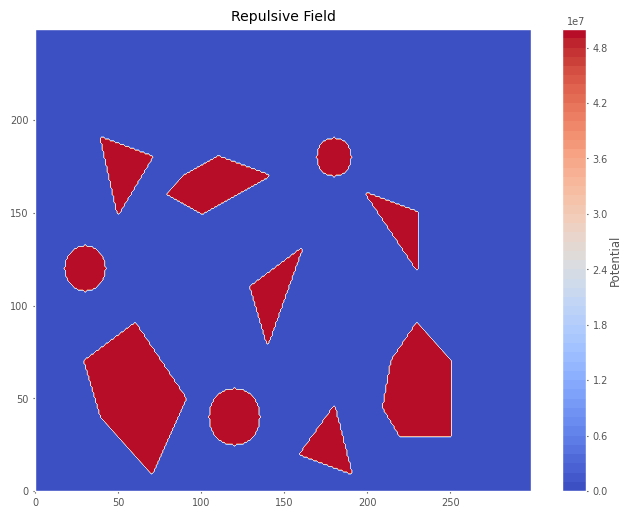

In [189]:
plt.figure(figsize=(8,6))
plt.contourf(repul_field_map, levels=50, cmap='coolwarm')
plt.title("Repulsive Field")
plt.colorbar(label="Potential")
plt.show()


6. Total Potential Field

In [190]:
total_field_map = attrac_field_map + repul_field_map


Plot Total Potential Field

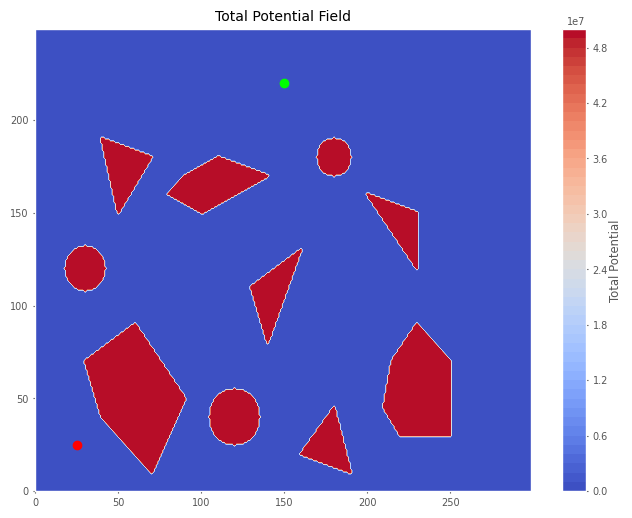

In [191]:
plt.figure(figsize=(8,6))
plt.contourf(total_field_map, levels=50, cmap='coolwarm')
plt.plot(start[0], start[1], 'o', color=[1, 0, 0])
plt.plot(goal[0], goal[1], 'o', color=[0, 1, 0])
plt.title("Total Potential Field")
plt.colorbar(label="Total Potential")
plt.show()


7. Gradient Field & Path Following

In [192]:
grad_y, grad_x = np.gradient(total_field_map)
total_field_map_gradient = np.stack((grad_x, grad_y), axis=-1)

def follow_force_field(force_field, start, goal, step_size=1.5, threshold=2, max_iters=30000):
    path = []
    p = np.array(start, dtype=np.float32)
    goal = np.array(goal, dtype=np.float32)

    for _ in range(max_iters):
        path.append(p.copy())
        i, j = int(round(p[1])), int(round(p[0]))
        if i < 0 or i >= force_field.shape[0] or j < 0 or j >= force_field.shape[1]:
            break

        f = force_field[i, j]
        norm = np.linalg.norm(f)
        if norm < 1e-6:
            break

        p += step_size * f / norm
        if np.linalg.norm(p - goal) < threshold:
            path.append(goal)
            break

    return np.array(path)

path = follow_force_field(-total_field_map_gradient, start, goal)


Plot Path Over Total Field

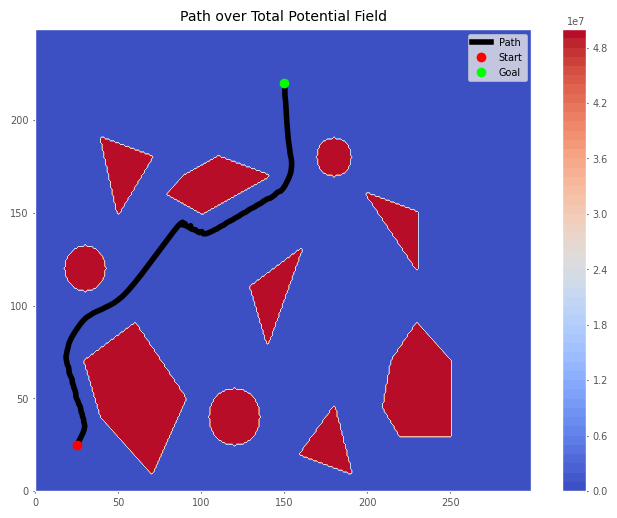

In [193]:
plt.figure(figsize=(8,6))
plt.contourf(total_field_map, levels=50, cmap='coolwarm')
plt.plot(path[:,0], path[:,1], 'k-', linewidth = '4', label="Path")
plt.plot(start[0], start[1], 'o', color=[1, 0, 0], label="Start")
plt.plot(goal[0], goal[1], 'o', color=[0, 1, 0], label="Goal")
plt.title("Path over Total Potential Field")
plt.colorbar()
plt.legend()
plt.show()


8. Gradient Vector Field

In [194]:
skip = 10
Y, X = np.mgrid[0:map_height:skip, 0:map_width:skip]
U = -total_field_map_gradient[::skip, ::skip, 0]
V = -total_field_map_gradient[::skip, ::skip, 1]


Plot Gradient Vectors

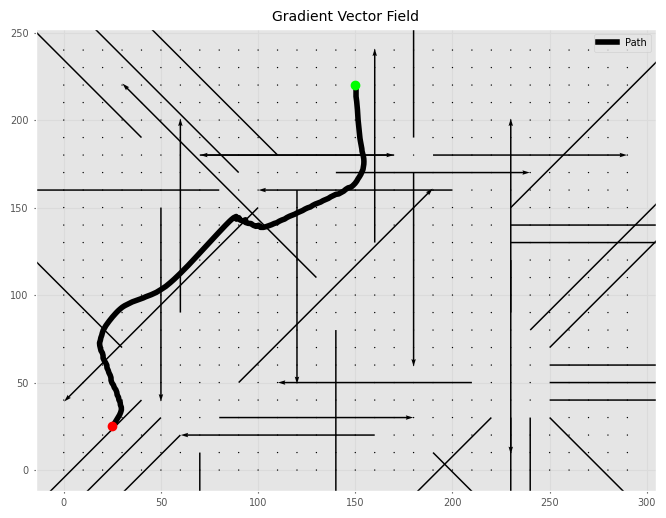

In [195]:
plt.figure(figsize=(8,6))
plt.quiver(X, Y, U, V)
plt.plot(path[:,0], path[:,1], 'k-', linewidth='4', label="Path")
plt.plot(start[0], start[1], 'o', color=[1, 0, 0])
plt.plot(goal[0], goal[1], 'o', color=[0, 1, 0])
plt.title("Gradient Vector Field")
plt.legend()
plt.show()


9. 3D Visualization

Plot 3D Visualization of Total Field

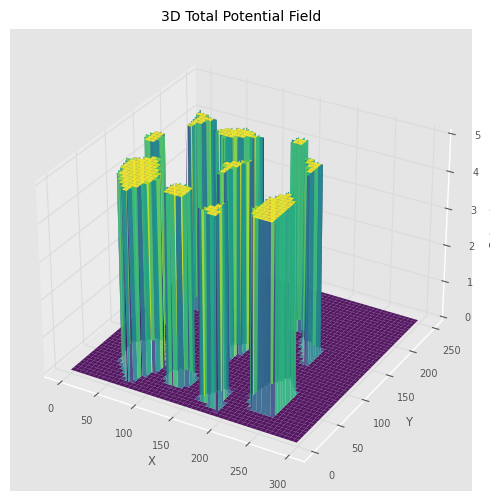

In [196]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(np.arange(map_width), np.arange(map_height))
ax.plot_surface(X, Y, total_field_map, cmap='viridis', edgecolor='none', alpha=0.9)
ax.set_title('3D Total Potential Field')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Potential')
plt.show()

Plot 3D Total Field with Path

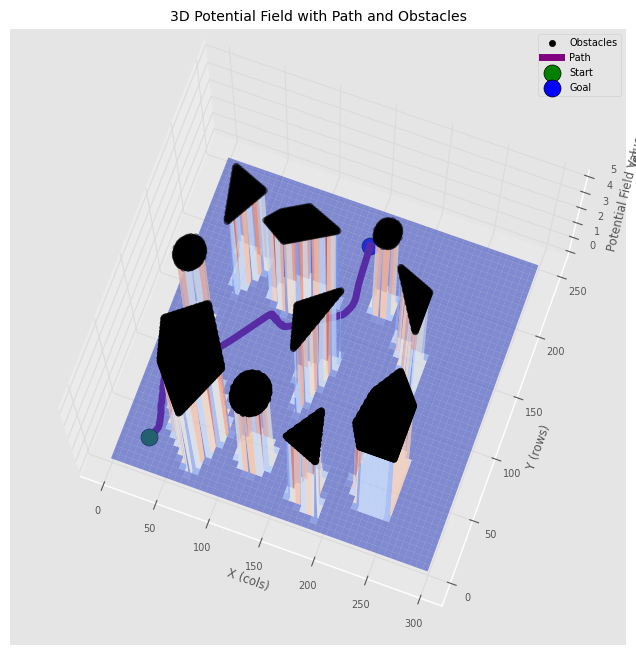

In [211]:
def plot_3d_path(field, path, binary_map, start, goal):
    X, Y = np.meshgrid(np.arange(field.shape[1]), np.arange(field.shape[0]))
    Z = field

    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot surface with lower alpha to see path better
    ax.plot_surface(X, Y, Z, cmap='coolwarm', alpha=0.6, edgecolor='none')

    # Obstacles at max height + offset
    obs_y, obs_x = np.where(binary_map == 1)
    ax.scatter(obs_x, obs_y, np.max(Z) + 10, color='black', s=20, label='Obstacles')

    if path.shape[0] > 0:
        # Lift path points higher for visibility
        z_path = Z[path[:,1].astype(int), path[:,0].astype(int)] + 10
        ax.plot(path[:,0], path[:,1], z_path, color='purple', linewidth=5, label='Path')

    # Start and goal markers raised above path and surface

    ax.scatter(start[0], start[1], color='green', s=150, label='Start',
           edgecolors='black', marker='o', zorder=10)
    ax.scatter(goal[0], goal[1], color='blue', s=150, label='Goal',
           edgecolors='black', marker='o', zorder=10)

    ax.set_xlabel('X (cols)')
    ax.set_ylabel('Y (rows)')
    ax.set_zlabel('Potential Field Value')

    ax.set_title('3D Potential Field with Path and Obstacles')
    ax.view_init(elev=75, azim=-70)
    ax.legend()
    plt.show()  

plot_3d_path(total_field_map, path, binary_map, start, goal)

**Conclusion**

This lab demonstrates the implementation of a potential field path planning algorithm for robotic navigation in a 2D environment with polygonal and circular obstacles. The approach effectively integrates geometric modeling, potential field theory, and gradient-based navigation to autonomously guide a robot from a specified start point to a goal. The approach effectively combines attractive potential fields that guide the robot toward the goal with repulsive fields that steer it away from obstacles, generating smooth, collision-free trajectories through gradient descent. The solution's strengths lie in its clear visualization capabilities, including 2D/3D potential field representations and gradient vector maps, as well as its flexibility in handling various obstacle configurations through adjustable parameters. However, the method inherits the classic limitations of potential field approaches, particularly susceptibility to local minima and a static environment assumption. 

In the final analysis, the algorithm demonstrates a smooth and obstacle-avoiding trajectory generation. Its performance is highly dependent on carefully tuned parameters such as the repulsive gain and influence distance.